In [4]:
import matplotlib.pyplot as plt
import numpy as np
	
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
	
from utils import decorate, savefig
!mkdir -p figs

In [5]:
class Simulation:
    def __init__(self, fit_land, agents):
        self.fit_land = fit_land
        self.agents = np.asarray(agents)
        self.instruments = []

In [6]:
    def add_instrument(self, instrument):
        self.instruments.append(instrument)
    			
    def plot(self, index, *args, **kwargs):
        self.instruments[index].plot(*args, **kwargs)

In [7]:
    def run(self, num_steps=500):
        self.update_instruments()
			
        for _ in range(num_steps):
            self.step()
                                
    def step(self):
        n = len(self.agents)
        fits = self.get_fitnesses()
			
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
			
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements
			
        self.update_instruments()

In [8]:
    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self)
    		
    def get_locs(self):
        return [tuple(agent.loc) for agent in self.agents]
			
    def get_fitnesses(self):
        fits = [agent.fitness for agent in self.agents]
        return np.array(fits)
    			
    def choose_dead(self, ps):
        n = len(self.agents)
        is_dead = np.random.random(n) < 0.1
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
			
    def choose_replacements(self, n, weights):
        agents = np.random.choice(self.agents, size=n, replace=True)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [9]:
class Instrument:
    def __init__(self):
        self.metrics = []
		
    def update(self, sim):
        pass
                    
    def plot(self, **options):
        plt.plot(self.metrics, **options)

In [10]:
def sum(a, b, c, d):
    return a + b + c + d
				
    values1 = (1, 2)
    values2 = { 'c': 10, 'd': 15 }
				
    s = sum(*values1, *values1)
    s = sum(*values1, **values2) 

In [11]:
class MeanFitness(Instrument):
    label = 'Mean fitness'

    def update(self, sim):
        mean = np.nanmean(sim.get_fitnesses())
        self.metrics.append(mean)

In [12]:
class Agent:
    keys = [(None, None),
            (None, 'C'),
            (None, 'D'),
            ('C', 'C'),
            ('C', 'D'),
            ('D', 'C'),
            ('D', 'D')]

    def __init__(self, values, fitness=np.nan):
        self.values = values
        self.responses = dict(zip(self.keys, values))
        self.fitness = fitness
                    
    def reset(self):
        self.hist = [None, None]
        self.score = 0
                    
    def past_responses(self, num=2):
        return tuple(self.hist[-num:])
                
    def respond(self, other):
        key = other.past_responses()
        resp = self.responses[key]
        return resp
                    
    def append(self, resp, pay):
        self.hist.append(resp)
        self.score += pay
                    
    def copy(self, prob_mutate=0.05):
        if np.random.random() > prob_mutate:
            values = self.values
        else:
            values = self.mutate()
        return Agent(values, self.fitness)
                
    def mutate(self):
        values = list(self.values)
        index = np.random.choice(len(values))
        values[index] = 'C' if values[index] == 'D' else 'D'
        return values

In [13]:
all_c = Agent('CCCCCCC')
all_c.responses
	
all_d = Agent('DDDDDDD')
all_d.responses
	
tft = Agent('CCDCDCD')
tft.responses

{(None, None): 'C',
 (None, 'C'): 'C',
 (None, 'D'): 'D',
 ('C', 'C'): 'C',
 ('C', 'D'): 'D',
 ('D', 'C'): 'C',
 ('D', 'D'): 'D'}

In [14]:
np.random.seed(17)
for i in range(10):
    print(all_d.copy().values)

DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
DDDDDDD
['D', 'C', 'D', 'D', 'D', 'D', 'D']
['D', 'D', 'C', 'D', 'D', 'D', 'D']


In [15]:
np.sum([all_d.copy().values != all_d.values for i in range(1000)])    



57

In [16]:
class Tournament:
	
    payoffs = {('C', 'C'): (3, 3),
               ('C', 'D'): (0, 5),
               ('D', 'C'): (5, 0),
               ('D', 'D'): (1, 1)}
    num_rounds = 6
		
    def play(self, agent1, agent2):
        agent1.reset()
        agent2.reset()
			
        for i in range(self.num_rounds):
            resp1 = agent1.respond(agent2)
            resp2 = agent2.respond(agent1)
				
            pay1, pay2 = self.payoffs[resp1, resp2]
				
            agent1.append(resp1, pay1)
            agent2.append(resp2, pay2)
                    
        return agent1.score, agent2.score
                        
    def melee(self, agents, randomize=True):
        if randomize:
            agents = np.random.permutation(agents)
                    
        n = len(agents)
        i_row = np.arange(n)
        j_row = (i_row + 1) % n
                
        totals = np.zeros(n)
			
        for i, j in zip(i_row, j_row):
            agent1, agent2 = agents[i], agents[j]
            score1, score2 = self.play(agent1, agent2)
            totals[i] += score1
            totals[j] += score2
                    
        for i in i_row:
            agents[i].fitness = totals[i] / self.num_rounds / 2


In [17]:
tour = Tournament()
tour.play(all_d, all_c)
	
tour.play(all_d, tft)
	
tour.play(tft, all_c)
	
agents = [all_c, all_d, tft]
agents
	
tour.melee(agents)


In [18]:
for agent in agents:
    print(agent.values, agent.fitness)


CCCCCCC 1.5
DDDDDDD 3.3333333333333335
CCDCDCD 1.9166666666666667


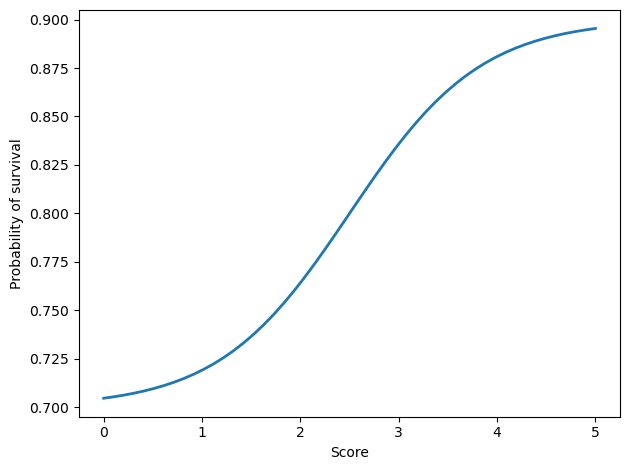

In [19]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    exponent = -B * (x - M)
    denom = C + Q * np.exp(exponent)
    return A + (K-A) / denom ** (1/nu)
	
def prob_survive(scores):
    return logistic(scores, A=0.7, B=1.5, M=2.5, K=0.9)
	
scores = np.linspace(0, 5)
probs = prob_survive(scores)
plt.plot(scores, probs)
decorate(xlabel='Score', ylabel='Probability of survival')


In [20]:
class PDSimulation(Simulation):
    def __init__(self, tournament, agents):
        self.tournament = tournament
        self.agents = np.asarray(agents)
        self.instruments = []
			
    def step(self):
        self.tournament.melee(self.agents)
        Simulation.step(self)
			
    def choose_dead(self, fits):
        ps = prob_survive(fits)
        n = len(self.agents)
        is_dead = np.random.random(n) < ps
        index_dead = np.nonzero(is_dead)[0]
        return index_dead


In [21]:
def make_random_agents(n):
    agents = [Agent(np.random.choice(['C', 'D'], size=7))
              for _ in range(n)]
    return agents
		
def make_identical_agents(n, values):
    agents = [Agent(values) for _ in range(n)]
    return agents


In [22]:
class Niceness(Instrument):
    label = 'Niceness'
		
    def update(self, sim):
        responses = np.array([agent.values for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)

class Opening(Instrument):
    label = 'Opening'
		
    def update(self, sim):
        responses = np.array([agent.values[0] for agent in sim.agents])
        metric = np.mean(responses == 'C')
        self.metrics.append(metric)
                
class Retaliating(Instrument):
    label = 'Retaliating'
		
    def update(self, sim):
        after_d = np.array([agent.values[2::2] for agent in sim.agents])
        after_c = np.array([agent.values[1::2] for agent in sim.agents])
        metric = np.mean(after_d == 'D') - np.mean(after_c == 'D')
        self.metrics.append(metric)
	
class Forgiving(Instrument):
    label = 'Forgiving'
		
    def update(self, sim):
        after_dc = np.array([agent.values[5] for agent in sim.agents])
        after_cd = np.array([agent.values[4] for agent in sim.agents])
        metric = np.mean(after_dc == 'C') - np.mean(after_cd == 'C')
        self.metrics.append(metric)
	
class Forgiving2(Instrument):
    label = 'Forgiving2'        
		
    def update(self, sim):
        after_two = np.array([agent.values[3:] for agent in sim.agents])
        metric = np.mean(np.any(after_two=='C', axis=1))
        self.metrics.append(metric)        


In [23]:
tour = Tournament()
	
agents = make_identical_agents(100, list('DDDDDDD'))
sim = PDSimulation(tour, agents)
	
sim.add_instrument(MeanFitness())
sim.add_instrument(Niceness())
sim.add_instrument(Opening())
sim.add_instrument(Retaliating())
sim.add_instrument(Forgiving()) 


AttributeError: 'PDSimulation' object has no attribute 'add_instrument'